# Creating summary tables that address relevant factors related to COVID-19 using TF-IDF Cosine Simlarity & Key Words /BERT 

This notebook is for task 2 only

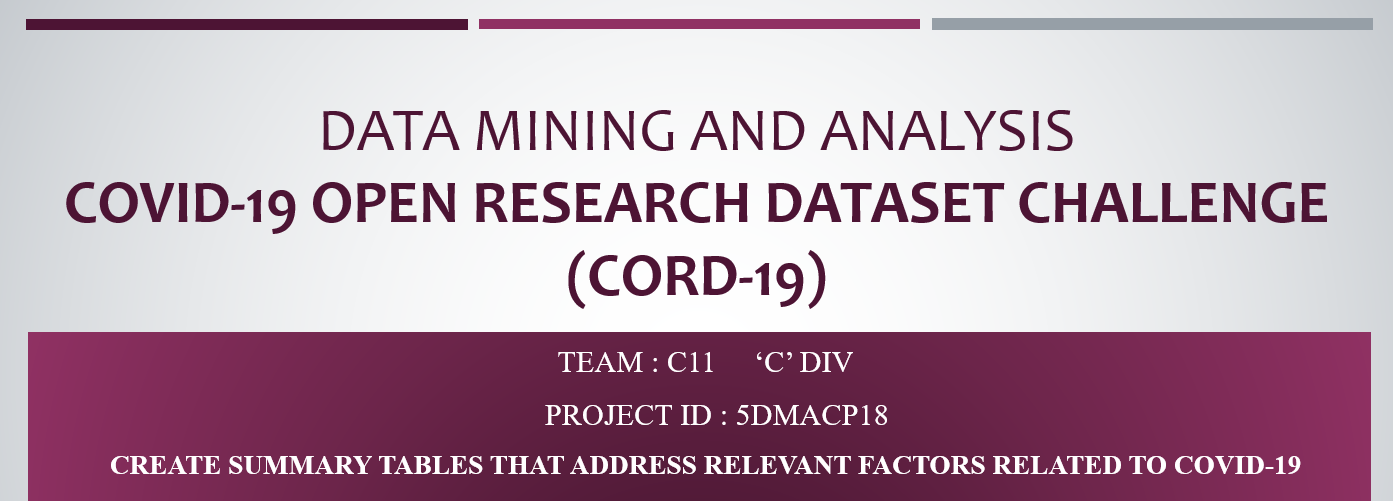

## Introduction
With the COVID-19 keeps ongoing, the number of research publications on COVID-19 is growing fast, making it increasingly difficult for researchers to spot the most relevant findings. This project aims to help the medical community find the information they seek by building data mining and search tools, which can ultimately support the ongoing fight against this pandemic. This notebook contains a basic pipeline of using NLP models to develop answers to high priority scientific questions regarding the COVID-19.

The pipeline in this notebook includes the following steps:
1. Initial Setup
2. Functions
3. Data Preparation
4. Paper Selection
4. Extract Answers for Summary Tables

# Initial Setup

## Load Libraries

In [1]:
# Import Packages
import os
import re
import nltk
import json
import torch
import nltk.corpus  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log, sqrt
from collections import defaultdict
from copy import deepcopy
import glob
import sys
import gzip, pickle, pickletools
from tqdm import tqdm
from pathlib import Path
from copy import deepcopy
from fuzzywuzzy import fuzz 
from nltk.stem import PorterStemmer
from datetime import datetime
from datetime import timedelta
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

!pip install transformers
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer
nltk.download('punkt')
nltk.download('stopwords')


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Functions
### Data Loading
- Function `format_name(author)`, `format_affiliation(affiliation)`, `format_authors(authors, with_affiliation=False)`, `format_body(body_text)`, and `format_bib(bibs)` each converts the paper-related information to standard format.
- Function `load_files(dirname)` loads the papers from json and saves them to a list.
- Function `clean_pdf_files(file_list, keyword_list)` takes a list of file and converts it to a dataframe with cleaned columns.

> The script for loading papers is based on: https://www.kaggle.com/xhlulu/cord-19-eda-parse-json-and-generate-clean-csv

### Data Cleaning
- Function `clean_sent(sentence)` cleans the text by lowercasing all words, removing numbers, punctuations, and stopwords, and stemming all words.

### Paper Selection
- Function `calc_simlarity_score(question_list, text_list,threshold=None, top=None)` calculates the similarity score between the TF-IDF matrix of the article and that of questions.
- Function `retrieve_paper(df, dic)` retrieves the information of relevant papers for each question in the specific topic.

> The code for TF-IDF cosine similarity is based on: https://github.com/mbulusu/Duplicate-Document-Detection-Meetup-Presentation

### Extract Answers for Summary Tables
- Function `hasNumbers(inputString)` determines if a string contains any digit, which is used to filter answers to certain questions that expect the answer to be a digit. 
- Function `col_fill(col_questions,col_names,col_for_excerpt,may_not_have_num,index)` fills the summary table with the existing columns from the paper collection(if available).
- Function `answer_question(question, answer_text)` extracts the information with given question.

> The code for Bert is based on: https://colab.research.google.com/drive/1uSlWtJdZmLrI3FCNIlUHFxwAJiSu2J0-

In [2]:
# Text Preprocessing `clean_sent()`----------------------------------------------------------------------
porter_stemmer = PorterStemmer()
def clean_sent(sentence):
    """
    Clean the sentence
    :param sentence: text to to be cleaned
    :return: text that has been cleaned
    """
    #nltk.FreqDist(words).most_common(10)
    stopwords = set(nltk.corpus.stopwords.words('english'))
    words = sentence.split()
    # Lowercase all words (default_stopwords are lowercase too)
    words = [word.lower() for word in words]
    #words = sentence
    words = [word for word in words if len(word) > 1]
    # Remove numbers
    words = [word for word in words if not word.isnumeric()]
    # Remove punctuation
    words = [word for word in words if word.isalpha()]
    # Remove stopwords
    words = [word for word in words if word not in stopwords]
    # Porter
    words = [porter_stemmer.stem(word) for word in words]
    #fdist = nltk.FreqDist(words_lc)   
    return " ".join(words)


In [3]:



## Data Load----------------------------------------------------------------------

def format_name(author):
    middle_name = " ".join(author['middle'])
    if author['middle']:
        return " ".join([author['first'], middle_name, author['last']])
    else:
        return " ".join([author['first'], author['last']])

def format_affiliation(affiliation):
    text = []
    location = affiliation.get('location')
    if location:
        text.extend(list(affiliation['location'].values()))

    institution = affiliation.get('institution')
    if institution:
        text = [institution] + text
    return ", ".join(text)

def format_authors(authors, with_affiliation=False):
    name_ls = []

    for author in authors:
        name = format_name(author)
        if with_affiliation:
            affiliation = format_affiliation(author['affiliation'])
            if affiliation:
                name_ls.append(f"{name} ({affiliation})")
            else:
                name_ls.append(name)
        else:
            name_ls.append(name)

    return ", ".join(name_ls)

def format_body(body_text):
    texts = [(di['section'], di['text']) for di in body_text]
    texts_di = {di['section']: "" for di in body_text}

    for section, text in texts:
        texts_di[section] += text

    body = ""

    for section, text in texts_di.items():
        body += section
        body += "\n\n"
        body += text
        body += "\n\n"

    return body

def format_bib(bibs):
    if type(bibs) == dict:
        bibs = list(bibs.values())
    bibs = deepcopy(bibs)
    formatted = []

    for bib in bibs:
        bib['authors'] = format_authors(
            bib['authors'],
            with_affiliation=False
        )
        formatted_ls = [str(bib[k]) for k in ['title', 'authors', 'venue', 'year']]
        formatted.append(", ".join(formatted_ls))

    return "; ".join(formatted)

def load_files(dirname):
    filenames = os.listdir(dirname)
    raw_files = []

    for filename in tqdm(filenames):
        filename = dirname + filename
        file = json.load(open(filename, 'rb'))
        raw_files.append(file)

    return raw_files

In [4]:


def clean_pdf_files(file_list,no_of_article):
    nth_paper=0
    cleaned_files=[]
    for file in file_list:
        if no_of_article+1 == nth_paper:
            break
        try:
            with open(file) as f:
                file=json.load(f)
            features = [
                file['paper_id'],
                file['metadata']['title'],
                format_authors(file['metadata']['authors']),
                format_authors(file['metadata']['authors'],
                               with_affiliation=True),
                format_body(file['abstract']),
                format_body(file['body_text']),
                format_bib(file['bib_entries']),
                file['metadata']['authors'],
                file['bib_entries']
            ]
            if(nth_paper%1000) == 0:
                print(nth_paper)
            nth_paper=nth_paper+1
            cleaned_files.append(features)
        except:
            yzidff = 1
    col_names = ['paper_id', 'title', 'authors',
                 'affiliations', 'abstract', 'text',
                 'bibliography','raw_authors','raw_bibliography']
    clean_df = pd.DataFrame(cleaned_files, columns=col_names)
    return clean_df

# Data Preparation
## 1. Load data
## Set directory

In [5]:
my_df= pd.DataFrame([])

file_path = "../input/CORD-19-research-challenge/"

# for df in pd.read_csv(file_path+'metadata.csv', iterator=True, chunksize=10000):  
#     my_df = my_df.append(pd.DataFrame(df))
my_df = pd.read_csv("/kaggle/input/CORD-19-research-challenge/metadata.csv")

my_df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

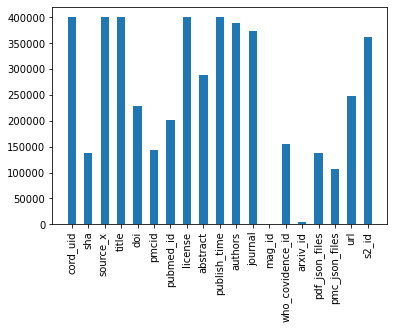

In [6]:
def display_barchart(my_df):
    column = my_df.columns.tolist()
    # https://datatofish.com/convert-pandas-dataframe-to-list/
    valid_cnt = list(my_df.count())
    plt.bar(column,valid_cnt,align = "center",width = 0.5,alpha = 1)
    plt.xticks(rotation=90)

    
display_barchart(my_df)

In [7]:

my_df.drop_duplicates(subset='title',keep='first')
my_df.drop_duplicates(subset='abstract',keep='first')
my_df.drop_duplicates(subset='doi',keep='first')
my_df.count()

cord_uid            400398
sha                 137332
source_x            400398
title               400187
doi                 229062
pmcid               144198
pubmed_id           200944
license             400398
abstract            287975
publish_time        400177
authors             388247
journal             374375
mag_id                   0
who_covidence_id    154684
arxiv_id              5265
pdf_json_files      137332
pmc_json_files      107643
url                 247305
s2_id               361980
dtype: int64

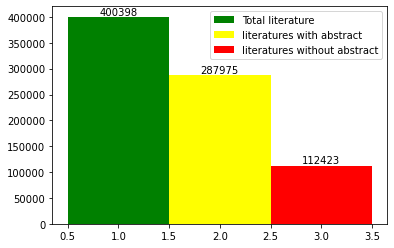

In [8]:

valid_cnt = list(my_df.count())
with_abstract = valid_cnt[8]
total = valid_cnt[0]
without_abstract  = total - with_abstract

tot = plt.bar(1,total,color='green',width = 1)
plt.annotate(str(total), xy=(1,total), ha='center', va='bottom')

abstract = plt.bar(2,with_abstract,color='yellow',width = 1)
plt.annotate(str(with_abstract), xy=(2,with_abstract), ha='center', va='bottom')

lost = plt.bar(3,without_abstract,color='red',width = 1)
plt.annotate(str(without_abstract), xy=(3,without_abstract), ha='center', va='bottom')

plt.legend((tot, abstract,lost), ('Total literature', 'literatures with abstract','literatures without abstract'))

In [9]:
my_df.dropna(how='all')
my_df.dropna(subset=['abstract'],inplace=True)
my_df.count()


cord_uid            287975
sha                 113438
source_x            287975
title               287934
doi                 174207
pmcid               106155
pubmed_id           156011
license             287975
abstract            287975
publish_time        287772
authors             285104
journal             265434
mag_id                   0
who_covidence_id    100033
arxiv_id              5265
pdf_json_files      113438
pmc_json_files       87263
url                 189502
s2_id               264044
dtype: int64

In [10]:
my_df = my_df[pd.DatetimeIndex(my_df.publish_time).year>2018]
# https://www.interviewqs.com/ddi_code_snippets/extract_month_year_pandas
# https://stackoverflow.com/questions/13851535/delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression-involving
my_df.info()

df = my_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215879 entries, 3480 to 400396
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          215879 non-null  object 
 1   sha               78388 non-null   object 
 2   source_x          215879 non-null  object 
 3   title             215838 non-null  object 
 4   doi               112313 non-null  object 
 5   pmcid             69224 non-null   object 
 6   pubmed_id         90975 non-null   object 
 7   license           215879 non-null  object 
 8   abstract          215879 non-null  object 
 9   publish_time      215879 non-null  object 
 10  authors           213750 non-null  object 
 11  journal           194063 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  99008 non-null   object 
 14  arxiv_id          5074 non-null    object 
 15  pdf_json_files    78388 non-null   object 
 16  pmc_json_files   

In [11]:

my_df = df
covid_terms =['covid', 'coronavirus disease 19', 'sars cov 2', '2019 ncov', '2019ncov', '2019 n cov', '2019n cov',
              'ncov 2019', 'n cov 2019', 'coronavirus 2019', 'wuhan pneumonia', 'wuhan virus', 'wuhan coronavirus',
              'coronavirus 2', 'covid-19', 'SARS-CoV-2', '2019-nCov']
covid_terms = [elem.lower() for elem in covid_terms]
covid_terms = re.compile('|'.join(covid_terms))

def checkYear(date):
    return int(date[0:4])

def checkCovid(row, covid_terms):
    return bool(covid_terms.search(row['abstract'].lower())) and checkYear(row['publish_time']) > 2019



In [12]:
my_df['is_covid'] = my_df.apply(checkCovid, axis=1, covid_terms=covid_terms)
my_df.head()

cord_uid                                       sha source_x  \
3480  gcj14snd  1d05dbf38f98918269d71020f0c9ff616548c2df      PMC   
3562  qlwzl5mq  4c7f6c52fe043745887db5406196b1d5099c9614      PMC   
3581  eqgc8v7y  e5c06914d0daee6e881665b23adca340d0a6271a      PMC   
3593  c22kw6f4  ae56d60debc175395e6269fc5bf9184291e71a56      PMC   
3594  hbpk850a  ca8f30a35b564945dd2588c382a0e181a1e08662      PMC   

                                                  title  \
3480  Human rhinovirus spatial-temporal epidemiology...   
3562  Multiple Introductions of Domestic Cat Feline ...   
3581  Impact of glucose-6-phosphate dehydrogenase de...   
3593  Improvement in the survival rates of extracorp...   
3594  Mental health workers perceptions of disaster ...   

                                   doi       pmcid pubmed_id license  \
3480  10.12688/wellcomeopenres.14836.2  PMC6234744  30483602   cc-by   
3562            10.3201/eid2501.181347  PMC6302599  30561312   no-cc   
3581      10.1371/journal.pone.0209204  PMC6314580  30601843   cc-by   
3593         10.1186/s13054-018-2293-5  PMC6318967  30606235   cc-by   
3594         10.1186/s12889-018-6313-9  PMC6318987  30606149   cc-by   

                                               abstract publish_time  \
3480  Background: Human rhinovirus (HRV) is the pred...   2019-03-27   
3562  The endangered Florida panther (Puma concolor ...   2019-01-03   
3581  Glucose-6-phosphate dehydrogenase (G6PD) defic...   2019-01-02   
3593  BACKGROUND: Although the utilization of extrac...   2019-01-03   
3594  BACKGROUND: The post-disaster mental health cr...   2019-01-03   

                                                authors            journal  \
3480  Morobe, John Mwita; Nyiro, Joyce U.; Brand, Sa...  Wellcome Open Res   
3562  Chiu, Elliott S.; Kraberger, Simona; Cunningha...   Emerg Infect Dis   
3581  May, Win Lai; Kyaw, Myat Phone; Blacksell, Stu...           PLoS One   
3593  Baek, Moon Seong; Lee, Sang-Min; Chung, Chi Ry...          Crit Care   
3594  Xi, Yingjun; Chen, Runsen; Gillespie, Amy L.; ...  BMC Public Health   

      mag_id who_covidence_id arxiv_id  \
3480     NaN              NaN      NaN   
3562     NaN              NaN      NaN   
3581     NaN              NaN      NaN   
3593     NaN              NaN      NaN   
3594     NaN              NaN      NaN   

                                         pdf_json_files  \
3480  document_parses/pdf_json/1d05dbf38f98918269d71...   
3562  document_parses/pdf_json/4c7f6c52fe043745887db...   
3581  document_parses/pdf_json/e5c06914d0daee6e88166...   
3593  document_parses/pdf_json/ae56d60debc175395e626...   
3594  document_parses/pdf_json/ca8f30a35b564945dd258...   

                                    pmc_json_files  \
3480  document_parses/pmc_json/PMC6234744.xml.json   
3562  document_parses/pmc_json/PMC6302599.xml.json   
3581  document_parses/pmc_json/PMC6314580.xml.json   
3593  document_parses/pmc_json/PMC6318967.xml.json   
3594  document_parses/pmc_json/PMC6318987.xml.json   

                                                    url  s2_id  is_covid  
3480  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...    NaN     False  
3562  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...    NaN     False  
3581  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...    NaN     False  
3593  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...    NaN     False  
3594  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...    NaN     False

In [13]:
df_covid_only = my_df[my_df['is_covid']==True]
df_covid_only = df_covid_only.reset_index(drop=True)
df_covid_only.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147290 entries, 0 to 147289
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          147290 non-null  object 
 1   sha               51057 non-null   object 
 2   source_x          147290 non-null  object 
 3   title             147257 non-null  object 
 4   doi               67466 non-null   object 
 5   pmcid             43210 non-null   object 
 6   pubmed_id         54395 non-null   object 
 7   license           147290 non-null  object 
 8   abstract          147290 non-null  object 
 9   publish_time      147290 non-null  object 
 10  authors           146695 non-null  object 
 11  journal           130324 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  77294 non-null   object 
 14  arxiv_id          2968 non-null    object 
 15  pdf_json_files    51057 non-null   object 
 16  pmc_json_files    34

In [14]:
key_words = ['transmission','transmitted','long','symptomatic','asymptomatic','infected','infection','range', 'incubation', 'periods', 'surfaces', 'prevent','protective','SARS-CoV-2','infectious','reported','respiratory', 'secretions', 'saliva', 'droplets','short', 'time', 'fomites','sanitation']
pattern = '|'.join(key_words)
df_covid_only = df_covid_only.loc[df_covid_only['abstract'].str.contains(pattern, case=False)]
df_covid_only.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122204 entries, 0 to 147289
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          122204 non-null  object 
 1   sha               43898 non-null   object 
 2   source_x          122204 non-null  object 
 3   title             122181 non-null  object 
 4   doi               57455 non-null   object 
 5   pmcid             36373 non-null   object 
 6   pubmed_id         45940 non-null   object 
 7   license           122204 non-null  object 
 8   abstract          122204 non-null  object 
 9   publish_time      122204 non-null  object 
 10  authors           121846 non-null  object 
 11  journal           108296 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  62871 non-null   object 
 14  arxiv_id          2342 non-null    object 
 15  pdf_json_files    43898 non-null   object 
 16  pmc_json_files    29

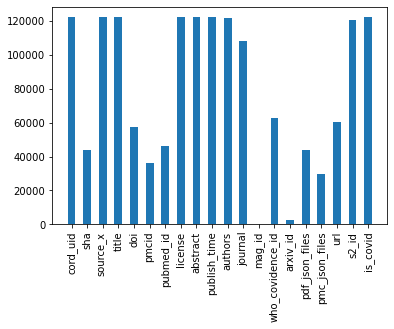

In [15]:
pd.options.display.max_colwidth = 100
df_covid_only.head().abstract
display_barchart(df_covid_only)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43898 entries, 0 to 147289
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cord_uid          43898 non-null  object 
 1   sha               43898 non-null  object 
 2   source_x          43898 non-null  object 
 3   title             43898 non-null  object 
 4   doi               42260 non-null  object 
 5   pmcid             34031 non-null  object 
 6   pubmed_id         32340 non-null  object 
 7   license           43898 non-null  object 
 8   abstract          43898 non-null  object 
 9   publish_time      43898 non-null  object 
 10  authors           43858 non-null  object 
 11  journal           35401 non-null  object 
 12  mag_id            0 non-null      float64
 13  who_covidence_id  0 non-null      object 
 14  arxiv_id          1740 non-null   object 
 15  pdf_json_files    43898 non-null  object 
 16  pmc_json_files    28345 non-null  objec

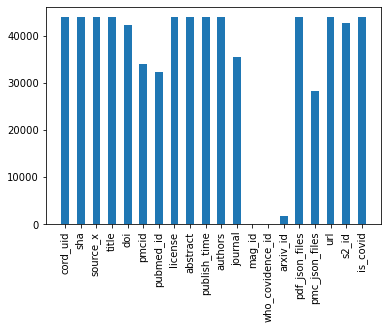

In [16]:

df_covid_only.dropna(subset=['pdf_json_files'],inplace=True)
df_covid_only.info()
display_barchart(df_covid_only)

In [17]:
base_path = '../input/CORD-19-research-challenge/'
file_list = df_covid_only['pdf_json_files']
file_list = [base_path+x for x in file_list]
print(file_list[0])

../input/CORD-19-research-challenge/document_parses/pdf_json/5a17ed3e4abf295f5820c65f56398266c1baae98.json


### Load relevant papers
* Load the papers and related information to the data structure.
* Filter the papers to only articles related to COVID-19.

In [18]:
#Set the no_of_articles you want to load(Right now max = 40k)
clean_pdf_df = clean_pdf_files(file_list,43898)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000


# 2. Combine selected papers with the metadata

In [19]:
# Append additional info from metadata to main df
metadata = pd.read_csv("/kaggle/input/CORD-19-research-challenge/metadata.csv")
clean_pdf_df = clean_pdf_df.merge(metadata[['sha', 'title', 'authors', 'abstract', 'doi', 'publish_time', 'journal']], 
                                  how ='left', left_on='paper_id', right_on='sha')

# Clean columns
clean_pdf_df['title_x'] = clean_pdf_df['title_x'].fillna(clean_pdf_df['title_y'])
clean_pdf_df['authors_x'] = clean_pdf_df['authors_x'].fillna(clean_pdf_df['authors_y'])
clean_pdf_df['abstract_x'] = clean_pdf_df['abstract_x'].fillna(clean_pdf_df['abstract_y'])
clean_pdf_df = clean_pdf_df.drop(['sha', 'title_y', 'authors_y', 'abstract_y'], axis=1)
clean_pdf_df = clean_pdf_df.rename(columns={'title_x': 'title', 'authors_x': 'authors', 'abstract_x': 'abstract'})

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 3. Data preprocessing
* Use lowercase for all content.
* Remove numbers, punctuations, stopwords.
* Remove the commoner morphological and inflexional endings from words in English.

In [20]:
clean_pdf_df['text_cleaned'] = clean_pdf_df.apply(lambda row: clean_sent(row['text']), axis=1)

In [21]:
clean_pdf_df.shape

(41298, 13)

In [22]:
clean_pdf_df.drop_duplicates(subset="title",keep = 'first',inplace = True)
clean_pdf_df.head()

paper_id  \
0  5a17ed3e4abf295f5820c65f56398266c1baae98   
1  36e2047d1674c3095617f3eb97f9f61e48989dfe   
3  d049cc13cfc0854eef6913f1c11eece8792b89fc   
4  670f5fc39bbb8591f12fbd8b4192ca3f12dd8791   
5  3cc8e5005005a3129a3531f80acb35cf22f2dc00   

                                                                                                 title  \
0  Open Peer Review Therapeutic strategies in an outbreak scenario to treat the novel coronavirus o...   
1                                      Artificial Intelligence (AI) applications for COVID-19 pandemic   
3  Practical Considerations When Performing Neurodiagnostic Studies on Patients with COVID-19 and O...   
4                                                                     Pandemic on Imaging Case Volumes   
5  of the Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)(https://creat...   

                                                                                               authors  \
0                                                                          Robert L Kruse, Yi-Wei Tang   
1                                          Raju Vaishya, Mohd Javaid, Ibrahim Haleem Khan, Abid Haleem   
3  Seline Haines, R Eeg, / Ep, T , Amy Caccamo, Fonda Chan, German Galaso, Alexis Catinchi, Puneet ...   
4      Jason J Q12 Naidich, Artem Boltyenkov, Jason J Wang, Jesse Chusid, Danny Hughes, Pina C Sanelli   
5                                 Revista Española De Quimioterapia, Jordi Reina Revisión, Jordi Reina   

                                                                                          affiliations  \
0  Robert L Kruse (Johns Hopkins Hospital, 21287, Baltimore, Shanghai, Maryland, USA, China), Yi-We...   
1  Raju Vaishya (Indraprastha Apollo Hospital, SaritaVihar, Mathura Road, 110076, New Delhi, India)...   
3  Seline Haines, R Eeg, / Ep, T , Amy Caccamo, Fonda Chan, German Galaso, Alexis Catinchi, Puneet ...   
4      Jason J Q12 Naidich, Artem Boltyenkov, Jason J Wang, Jesse Chusid, Danny Hughes, Pina C Sanelli   
5  Revista Española De Quimioterapia (Hospital Universitario Son Espases, 07120, Palma de Mallorca,...   

                                                                                              abstract  \
0  Abstract\n\nA novel coronavirus (2019-nCoV) originating in Wuhan, China presents a potential res...   
1  Abstract\n\nBackground and aims: Healthcare delivery requires the support of new technologies li...   
3  Abstract\n\nThe coronavirus disease 2019, SARS-COV-2 (the cause of , has led to a worldwide shor...   
4  Abstract\n\nObjective: The coronavirus disease 2019 (COVID-19) pandemic has had significant econ...   
5  Abstract\n\nwith the capacity to inhibit the replication of the new virus. Among them, remdesivi...   

                                                                                                  text  \
0  Amendments from Version 1 Introduction\n\nA mysterious illness causing pneumonia in December 201...   
1  Background\n\nIn this worldwide health crisis, the medical industry is looking for new technolog...   
3  \n\nABSTRACT. The coronavirus disease 2019, SARS-COV-2 (the cause of , has led to a worldwide sh...   
4  INTRODUCTION\n\nIn a short time, the coronavirus disease 2019 (COVID-19) pandemic has had a deva...   
5  \n\nEl 31 de diciembre de 2019 se detectó en la ciudad de Wuhan (China) un brote neumonía de eti...   

                                                                                          bibliography  \
0  A Novel Coronavirus from Patients with Pneumonia in China, N Zhu, D Zhang, W Wang, N Engl J Med,...   
1  Effects of COVID 19 pandemic in daily life, A Haleem, M Javaid,  Vaishya, Curr Med Res Pract, 20...   
3  Supporting the health care workforce during the COVID-19 global epidemic, J G Adams, R M Walls, ...   
4  United States,  Worldometer, , 2020; COVID-19 data,  Nyc,  Health, , 2020; Unemployment rate, , ...   
5  Another decade, another coronaviru

In [23]:
clean_pdf_df.shape

(36681, 13)

# Paper selection
The relevant papers for each question are selected by calculating the cosine similarity score based on the TF-IDF pair of articles and questions. 

TF-IDF is a statistical measure that evaluates how important a word is to a document when compared against the other document in the corpus. In this project, both articles and questions are converted to TF-IDF matrix so that the information can be captured with fewer words and can be used for calculation.

Cosine similarity is a commonly used metric to measure the similarity between two vectors by taking the dot product divided by the product of two vector’s length. In this project, cosine similarity is used to measure the similarity between the TF-IDF matrix pair of documents and questions. In this way, the level of relevance can be quantified, which ultimately helps us to identify the most relevant papers for each question against more than 6,000 articles.


## 1. Set cleaned text and topic

In [24]:
text_cleaned = clean_pdf_df['text_cleaned']
path = '/kaggle/input/CORD-19-research-challenge/Kaggle/target_tables/2_relevant_factors/'

file_list = sorted(list(Path(path).glob('*.csv')))
questions = [file.name.split(".csv")[0].strip('_') for file in file_list]
questions_cleaned = [clean_sent(ques) for ques in questions]
for i,q in enumerate(questions):
    print("Question" ,i + 1,":",q)

Question 1 : Effectiveness of a multifactorial strategy to prevent secondary transmission
Question 2 : Effectiveness of case isolation_isolation of exposed individuals to prevent secondary transmission
Question 3 : Effectiveness of community contact reduction
Question 4 : Effectiveness of inter_inner travel restriction
Question 5 : Effectiveness of school distancing
Question 6 : Effectiveness of workplace distancing to prevent secondary transmission
Question 7 : Evidence that domesticated_farm animals can be infected and maintain transmissibility of the disease
Question 8 : How does temperature and humidity affect the transmission of 2019-nCoV
Question 9 : Methods to understand and regulate the spread in communities
Question 10 : Seasonality of transmission
Question 11 : What is the likelihood of significant changes in transmissibility in changing seasons


## 2. Build table structures with given target tables

In [25]:
table_cols_dic={}
table_dic={}
target_table_dic={}
for i,file in enumerate(file_list):
    df=pd.read_csv(file)
    cols=list(df.columns)
    table_cols_dic[i]=cols[1:]
    table_dic[i]=df
    target_table_dic[i]=pd.DataFrame(columns=cols)
[print(table_cols_dic[key]) for key in table_cols_dic.keys()]

['Date', 'Study', 'Study Link', 'Journal', 'Study Type', 'Factors', 'Influential', 'Excerpt', 'Measure of Evidence', 'Added on']
['Date', 'Study', 'Study Link', 'Journal', 'Study Type', 'Factors', 'Influential', 'Excerpt', 'Measure of Evidence', 'Added on']
['Date', 'Study', 'Study Link', 'Journal', 'Study Type', 'Factors', 'Influential', 'Excerpt', 'Measure of Evidence', 'Added on']
['Date', 'Study', 'Study Link', 'Journal', 'Study Type', 'Factors', 'Influential', 'Excerpt', 'Measure of Evidence', 'Added on']
['Date', 'Study', 'Study Link', 'Journal', 'Study Type', 'Factors', 'Influential', 'Excerpt', 'Measure of Evidence', 'Added on']
['Date', 'Study', 'Study Link', 'Journal', 'Study Type', 'Factors', 'Influential', 'Excerpt', 'Measure of Evidence', 'Added on']
['Date', 'Study', 'Study Link', 'Journal', 'Study Type', 'Factors', 'Infuential', 'Excerpt', 'Measure of Evidence', 'Added on']
['Date', 'Study', 'Study Link', 'Journal', 'Study Type', 'Factors', 'Influential', 'Excerpt', 'Mea

[None, None, None, None, None, None, None, None, None, None, None]

In [26]:
# BERT----------------------------------------------------------------------

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text,max_length=500)

    # Report how long the input sequence is.
    #print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example question through the model.
    start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                    token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)
    
    
    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]
            
    s_scores = start_scores.detach().numpy().flatten()
    e_scores = end_scores.detach().numpy().flatten()

    return answer


# Similarity ----------------------------------------------------------------------

def calc_simlarity_score(question_list, text_list,threshold=None, top=None):
    if (threshold==None)  and  (top==None):
        raise ValueError("Parameter `threshold` and `top` cannot both be None")
    dic = {}
    tfidf = TfidfVectorizer()
    corpus_tfidf_matrix = tfidf.fit_transform(text_list)
    ques_tfidf_matrix = tfidf.transform(question_list)
    sim_matrix = cosine_similarity(corpus_tfidf_matrix, ques_tfidf_matrix)
    for ques_idx in range(sim_matrix.shape[1]):
        dic[ques_idx] = []
        if threshold != None:
            if (threshold>1) or (threshold <0):
                raise ValueError("Please enter a value from 0 to 1 for parameter `threshold`")
            for paper_idx in range(sim_matrix.shape[0]):
                score = sim_matrix[paper_idx, ques_idx]
                if score >= threshold:
                    dic[ques_idx].append((paper_idx, score))
            dic[ques_idx]=sorted(dic[ques_idx], key=lambda i: i[1], reverse=True)
        elif top != None:
            top_paper_idx_list = sorted(range(len(sim_matrix[:, ques_idx])), key=lambda i: sim_matrix[:,0][i], reverse=True)[:top]
            dic[ques_idx] = [(top_idx, sim_matrix[top_idx, ques_idx]) for top_idx in top_paper_idx_list]
    return dic, sim_matrix



# Retrieve relevant paper----------------------------------------------------------------------

def retrieve_paper(df, dic):
    df_dic={}
    for ques_idx in dic:
        new_df = df.iloc[[item[0] for item in dic[ques_idx]], :]
        new_df['score'] = [item[1] for item in dic[ques_idx]]
        new_df['question'] = questions[ques_idx]
        df_dic[ques_idx]=new_df.copy()
    return df_dic



# Determine if a string has a value----------------------------------------------------------------------

def hasNumbers(inputString):
     return any(char.isdigit() for char in inputString)

## 3. Select relevant papers by TF-IDF cosine similarity

In [27]:

text_cleaned = clean_pdf_df['text_cleaned']
dic, sim_matrix = calc_simlarity_score(questions_cleaned, text_cleaned, threshold=0.15)
relevant_paper_dic = retrieve_paper(clean_pdf_df, dic)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Lets try to build the summary table for Question_8 of task_2 :

In [28]:
relevant_paper_dic[7].head()

paper_id  \
23644  0307ed3e17b1b04a01d9349eac1e6a4e5f200f84   
4300   8d48ad961c8d532c82fa468d7dd4f6d6c0b9819d   
37128  e274710f72ad711efc32bd1d51e7ed7b6786b1cc   
13640  b97ff8128bce1b8c92c891fd0b9d2383355dbbed   
28791  66b59a41f98fdb82cec94f7473041b7b9df59447   

                                                                                                     title  \
23644                                                       Will Coronavirus Disease 2019 Become Seasonal?   
4300   Environmental risk factors of airborne viral transmission: Humidity, Influenza and SARS-CoV-2 in...   
37128  Journal Pre-proof Association between temperature, humidity, and COVID-19 outbreaks in Banglades...   
13640  Investigating the effects of absolute humidity and human encounters on transmission of COVID-19 ...   
28791                   Effects of temperature and humidity on the spread of COVID-19: A systematic review   

                                                                                                   authors  \
23644                                  Mia Kanzawa, Hilary Spindler, Andrew Anglemyer, George W Rutherford   
4300                                                             Edsard Ravelli, Rolando Gonzales Martinez   
37128                                   Emdadul Syed, Mosiur Haque,  Rahman,  Haque, Mosiur Rahman,  Drphl   
13640                  Gary Lin, Alisa Hamilton, Oliver Gatalo, Fardad Haghpanah, Takeru Igusa, Eili Klein   
28791  Paulo Mecenasid, Renata Travassos Da, Rosa Moreira, Bastos 1☯, Antonio Carlos Rosá Rio Vallinoto...   

                                                                                              affiliations  \
23644  Mia Kanzawa (University of California, San Francisco, San Francisco, 2 The Kaiser Permanente Med...   
4300                                                             Edsard Ravelli, Rolando Gonzales Martinez   
37128  Emdadul Syed, Mosiur Haque,  Rahman,  Haque (UChicago Research Bangladesh, Dhaka, Bangladesh), M...   
13640  Gary Lin, Alisa Hamilton, Oliver Gatalo, Fardad Haghpanah, Takeru Igusa (Johns Hopkins Universit...   
28791  Paulo Mecenasid (Federal University of Pará, Belé m, Pará, Brazil), Renata Travassos Da, Rosa Mo...   

                                                                                                  abstract  \
23644  Abstract\n\nThis manuscript explores the question of the seasonality of severe acute respiratory...   
4300   Abstract\n\nThe relationship between specific humidity and influenza/SARS-CoV-2 in the Netherlan...   
37128  Abstract\n\n Peak spread of COVID-19 occurred at an average temperature of 26 0 C and a humidit...   
13640  Abstract\n\nMounting evidence suggests that the primary mode of transmission of SARS-CoV-2 is ae...   
28791  Abstract\n\nFaced with the global pandemic of COVID-19, declared by World Health Organization (W...   

                                                                                                      text  \
23644  \n\nAlthough the object of much speculation, few data exist that bear on the question of the sea...   
4300   Introduction\n\nPrevious experimental evidence indicates that that the aerosolization of secreti...   
37128  Introduction\n\nCoronavirus disease 2019 , caused by the novel coronavirus, 1 has become a serio...   
13640  Introduction\n\nTo date, the coronavirus disease 2019 (COVID- 19) pandemic has claimed over 225,...   
28791  \n\nIntroduction 2019. Faced with the global pandemic of COVID-19, declared by World Health Orga...   

                                                                                              bibliography  \
23644  Rapid expert consultation on SARS-CoV-2 survival in relation to temperature and humidity and pot...   
4300   Bayesian analysis of space-time variation in disease risk, L Bernardinelli, D Clayton, C Pascutt...   
37128  Early transmission dynamics in Wuhan, China, of novel coronavirus-infected pneumonia, Q Li

## 4. Add common columns to all summary tables

In [29]:
for key in target_table_dic.keys():
    target_table_dic[key][['Date', 'Study', 'Journal']]=relevant_paper_dic[key][['publish_time', 'title', 'journal']]
    target_table_dic[key]['Study Link'] = "https://doi.org/" + relevant_paper_dic[key]['doi']
    relevant_paper_dic[key]=relevant_paper_dic[key].reset_index(drop=True)
    target_table_dic[key]=target_table_dic[key].reset_index(drop=True)
    target_table_dic[key]['Added on'] = "10-Jun-2020"

In [30]:
for k,v in target_table_dic.items():
    print(k, ':', v.shape[0])

0 : 4
1 : 330
2 : 259
3 : 160
4 : 293
5 : 99
6 : 248
7 : 219
8 : 33
9 : 100
10 : 60


In [31]:
target_table_dic[1].head()

Unnamed: 0        Date  \
0        NaN  2020-06-05   
1        NaN  2020-09-17   
2        NaN  2020-08-21   
3        NaN  2020-02-12   
4        NaN  2020-08-07   

                                                                                                 Study  \
0                   Risk estimation of the SARS-CoV-2 acute respiratory disease outbreak outside China   
1                       Transmission of SARS-CoV-2: A Review of Viral, Host, and Environmental Factors   
2                                        Forecasting of COVID-19 Spread with dynamic transmission rate   
3  Simulating the infected population and spread trend of 2019-nCov under different policy by EIR m...   
4  O R I G I N A L A R T I C L E Evidence for pre-symptomatic transmission of coronavirus disease 2...   

                                     Study Link  \
0    https://doi.org/10.1186/s12976-020-00127-6   
1              https://doi.org/10.7326/m20-5008   
2  https://doi.org/10.1016/j.jnlssr.2020.07.003   
3   https://doi.org/10.1101/2020.02.10.20021519   
4             https://doi.org/10.1111/irv.12787   

                          Journal Study Type Factors Influential Excerpt  \
0            Theor Biol Med Model        NaN     NaN         NaN     NaN   
1                  Ann Intern Med        NaN     NaN         NaN     NaN   
2                             NaN        NaN     NaN         NaN     NaN   
3                             NaN        NaN     NaN         NaN     NaN   
4  Influenza Other Respir Viruses        NaN     NaN         NaN     NaN   

  Measure of Evidence     Added on  
0                 NaN  10-Jun-2020  
1                 NaN  10-Jun-2020  
2                 NaN  10-Jun-2020  
3                 NaN  10-Jun-2020  
4                 NaN  10-Jun-2020

# Extract Answers for Summary Tables

## Question: "How does temperature and humidity affect the transmission of 2019-nCoV?" `index: 7`

In [32]:
# question index
index=7
questions[index]

'How does temperature and humidity affect the transmission of 2019-nCoV'

In [33]:
# use key word to locate all key sentences and then use BERT to find out the question answers
question = "How does temperature and humidity affect the transmission of 2019-nCoV?"
excerpt_list=[]
question_factor = 'What are the factors of transmission?'
factor_list = []
measure_evidnc_list = []
measure_country_list = []
measure_timeline_list = []
study_type_list = []
question_study = "What is the study type or article research type like Systematic review, meta-analysis, Prospective observational study, Retrospective observational study, Observational study, Cross-sectional study, Case series, Expert review, Editorial, Simulation, or not found?"
question_measure_country = 'which country took measure on transmission'
question_measure_timeline = 'what timeline did they take measure on transmission'


for i, row in relevant_paper_dic[index].iterrows():    
    # Divide to sentences
    sent_list = row['text'].split('. ')
    
    # Find relevant sentences
    relevant_sent_list = [sent for sent in sent_list if ( ('temperature' in sent.lower()) & ('humidity' in sent.lower()) ) 
                          or ('effective' in sent.lower()) or ('factors' in sent.lower()) 
                          or ('timeline' in sent.lower()) or (('countries' in sent.lower()) or ('country' in sent.lower())) 
                          or ('measure' in sent.lower())
                          or ( ('transmission' in sent.lower()) & ('type' in sent.lower()) )]
    
    # Join sentences to form excerpt
    excerpt_string = '; \n'.join([sent for sent in relevant_sent_list])
    excerpt_list.append(excerpt_string)
    
    # run BERT on joined excerpt to get answer
    if excerpt_string != '':
        factor_ans = answer_question(question_factor, excerpt_string)
        measure_country_ans = answer_question(question_measure_country, excerpt_string)
        measure_timeline_ans = answer_question(question_measure_timeline, excerpt_string)
        study_ans = answer_question(question_study, excerpt_string)
        if not hasNumbers(measure_timeline_ans):
            measure_country_ans=''
        
        for a in [factor_ans, measure_country_ans,measure_timeline_ans,study_ans]:
            if ("[CLS]" in a) or ('[SEP]' in a):
                a = ""
            
    else:
        factor_ans = ''
        measure_country_ans = ''
        measure_timeline_ans = ''
        study_ans = ''
        
    # Save measure_factor to list
    factor_list.append(factor_ans)
    measure_country_list.append(measure_country_ans) # answer for measure of countries
    measure_timeline_list.append(measure_timeline_ans) # answer for measure of timeline
    study_type_list.append(study_ans)                          
    
target_table_dic[index]["Excerpt"]=excerpt_list
target_table_dic[index]['Factors'] = factor_list

for i,j in zip(measure_country_list,measure_timeline_list):
    measure_evidnc_list.append((i,j))
    
target_table_dic[index]['Measure of Evidence'] = measure_evidnc_list

In [34]:
target_table_dic[index]

Unnamed: 0        Date  \
0          NaN  2020-06-21   
1          NaN  2020-08-21   
2          NaN  2020-08-25   
3          NaN  2020-11-04   
4          NaN  2020-09-18   
..         ...         ...   
214        NaN  2020-05-15   
215        NaN  2020-11-08   
216        NaN  2020-09-04   
217        NaN  2020-06-25   
218        NaN  2020-07-21   

                                                                                                   Study  \
0                                                         Will Coronavirus Disease 2019 Become Seasonal?   
1    Environmental risk factors of airborne viral transmission: Humidity, Influenza and SARS-CoV-2 in...   
2    Journal Pre-proof Association between temperature, humidity, and COVID-19 outbreaks in Banglades...   
3    Investigating the effects of absolute humidity and human encounters on transmission of COVID-19 ...   
4                     Effects of temperature and humidity on the spread of COVID-19: A systematic review   
..                                                                                                   ...   
214                           The role of environmental factors to transmission of SARS-CoV-2 (COVID-19)   
215                   Inference under Superspreading: Determinants of SARS-CoV-2 Transmission in Germany   
216                                                 COVID-19 in Human, Animal, and Environment: A Review   
217  Determinants of the infection rate of the COVID-19 in the U.S. using ANFIS and virus optimizatio...   
218  Distributed under Creative Commons CC-BY 4.0 The effects of ''Fangcang, Huoshenshan, and Leishen...   

                                       Study Link                  Journal  \
0          https://doi.org/10.1093/infdis/jiaa345             J Infect Dis   
1     https://doi.org/10.1101/2020.08.18.20177444                      NaN   
2    https://doi.org/10.1016/j.envsci.2020.08.012       Environ Sci Policy   
3     https://doi.org/10.1101/2020.10.30.20223446                      NaN   
4    https://doi.org/10.1371/journal.pone.0238339                 PLoS One   
..                                            ...                      ...   
214    https://doi.org/10.1186/s13568-020-01028-0              AMB Express   
215                                           NaN                      NaN   
216      https://doi.org/10.3389/fvets.2020.00578            Front Vet Sci   
217   https://doi.org/10.1016/j.chaos.2020.110051  Chaos Solitons Fractals   
218            https://doi.org/10.7717/peerj.9578                    PeerJ   

    Study Type  \
0          NaN   
1          NaN   
2          NaN   
3          NaN   
4          NaN   
..         ...   
214        NaN   
215        NaN   
216        NaN   
217        NaN   
218        NaN   

                                                                                                 Factors  \
0                                                                                                  [CLS]   
1                                                                               humidity and temperature   
2                                                                                         meteorological   
3                                                                                      mobility patterns   
4                                                                                            temperature   
..                                                                                                   ...   
214                                                               ambient temperature , humidity , etc .   
215                                                                                                [CLS]   
216                                                                                                [CLS]   
217                                              wind speed , humidity , precipitation , and temperature   
218 

In [35]:
df1 = target_table_dic[index]
df1.head()

Unnamed: 0        Date  \
0        NaN  2020-06-21   
1        NaN  2020-08-21   
2        NaN  2020-08-25   
3        NaN  2020-11-04   
4        NaN  2020-09-18   

                                                                                                 Study  \
0                                                       Will Coronavirus Disease 2019 Become Seasonal?   
1  Environmental risk factors of airborne viral transmission: Humidity, Influenza and SARS-CoV-2 in...   
2  Journal Pre-proof Association between temperature, humidity, and COVID-19 outbreaks in Banglades...   
3  Investigating the effects of absolute humidity and human encounters on transmission of COVID-19 ...   
4                   Effects of temperature and humidity on the spread of COVID-19: A systematic review   

                                     Study Link             Journal  \
0        https://doi.org/10.1093/infdis/jiaa345        J Infect Dis   
1   https://doi.org/10.1101/2020.08.18.20177444                 NaN   
2  https://doi.org/10.1016/j.envsci.2020.08.012  Environ Sci Policy   
3   https://doi.org/10.1101/2020.10.30.20223446                 NaN   
4  https://doi.org/10.1371/journal.pone.0238339            PLoS One   

  Study Type                   Factors Influential  \
0        NaN                     [CLS]         NaN   
1        NaN  humidity and temperature         NaN   
2        NaN            meteorological         NaN   
3        NaN         mobility patterns         NaN   
4        NaN               temperature         NaN   

                                                                                               Excerpt  \
0  More specifically, winter months are generally associated with decreased temperatures, decreased...   
1  Recent studies also suggest the possibility of airborne transmission of SARS-CoV-2 through respi...   
2  2 COVID-19 is rapidly spreading in many of the western and temperate countries like Italy, Franc...   
3  Falling levels of absolute humidity have been shown to increase transmission rates of other resp...   
4  Faced with the global pandemic of COVID-19, declared by World Health Organization (WHO) on March...   

                                                                Measure of Evidence  \
0  ([CLS] which country took measure on transmission [SEP], before march 22 , 2020)   
1               (, [CLS] what timeline did they take measure on transmission [SEP])   
2               (, [CLS] what timeline did they take measure on transmission [SEP])   
3               (, [CLS] what timeline did they take measure on transmission [SEP])   
4        ([CLS] which country took measure on transmission [SEP], march 11 th 2020)   

      Added on  
0  10-Jun-2020  
1  10-Jun-2020  
2  10-Jun-2020  
3  10-Jun-2020  
4  10-Jun-2020

In [36]:
df1.to_csv('./target_table_temp_&_humidity.csv',index = True)

In [37]:
##new method to select study type and measure of evidence: select top 5 most related sentence for a specific question, and then find out the answer in the top 5 sentences
target_table_dic_2 = target_table_dic
def col_fill(col_questions,col_names,col_for_excerpt,may_not_have_num,index):
    """
    Get answers for multiple columns and append them back to target table (target_table_dic[index])
    :param col_questions: a list of string - questions, each corresponds to a specific column (excluding excerpt)
    :param col_names: a list of string - columns names in target table to which col_questions correspond
    :param col_for_excerpt: string - the most important question in col_questions, on which excerpt based
    :param may_not_have_num: a list of string - column names in col_names, to indicate columns that may not have digits (columns that not put in this list must have digits in its answer)
    :param index: question number in this task
    :return: target_table_dic[index] with content filled in designated columns 
    """
    col_questions_cleaned = [clean_sent(ques) for ques in col_questions]
    # go through papers
    for i in tqdm(range(relevant_paper_dic[index].shape[0])):
        #get sentences of each paper, preprocess it
        paper_sent=relevant_paper_dic[index].text[i].split(". ")
        cleaned_paper_sent = [clean_sent(t) for t in paper_sent]
        for num,q in enumerate(col_questions_cleaned):
            # define questions
            col_name=col_names[num]
            full_question= col_questions[num]
            # extract top 3 sentences/paper for a specific questions, join them together as a string
            lis=[]
            for sent in cleaned_paper_sent:
                lis.append(fuzz.ratio(q,sent) )
            top_3_idx = [item[0] for item in sorted(enumerate(lis), key=lambda x: x[1],reverse=True)[0:5]]
            #max_idx=max(enumerate(lis), key=lambda x: x[1])[0]
            string ='; \n'.join([paper_sent[idx] for idx in top_3_idx])
            # Get answers, delete those without a number 
            answer=answer_question(full_question,string)        
            if (not hasNumbers(answer)) and (col_name not in may_not_have_num):
                answer="" 
            if "[CLS]" in answer:
                answer = ""
            if "[SEP]" in answer:
                answer = ""
            target_table_dic_2[index].loc[i,col_name]=answer
            #  Exerpt answer extract
            if col_name == col_for_excerpt:
                excerpt_ans=string
                for idx in top_3_idx:
                    if (answer in paper_sent[idx]) and (answer!=""):
                        excerpt_ans=paper_sent[idx]
                target_table_dic_2[index].loc[i,"Excerpt"]=excerpt_ans
    return target_table_dic_2[index]

In [38]:
col_questions = ['How does temperature and humidity affect the transmission of 2019-nCoV?',
                 'Which country took measure on transmission',
                 'What timeline did they take measure on transmission',
                 "What is the study type or article research type like Systematic review, meta-analysis, Prospective observational study, Retrospective observational study, Observational study, Cross-sectional study, Case series, Expert review, Editorial, Simulation, or not found?"]

col_names=['Factors','Measure_country',"Measure_timeline","Study Type"]
col_for_excerpt='Factors'
may_not_have_num=['Factors','Measure_country',"Study Type"]

target_table_dic_2[index]=col_fill(col_questions,col_names,col_for_excerpt,may_not_have_num,index)

100%|██████████| 219/219 [16:03<00:00,  4.40s/it]


In [39]:
target_table_dic_2[index]['Measure of Evidence'] = target_table_dic_2[index].apply(lambda x: (x['Measure_country'], x['Measure_timeline']), axis = 1)

In [40]:
target_table_dic_2[index]

Unnamed: 0        Date  \
0          NaN  2020-06-21   
1          NaN  2020-08-21   
2          NaN  2020-08-25   
3          NaN  2020-11-04   
4          NaN  2020-09-18   
..         ...         ...   
214        NaN  2020-05-15   
215        NaN  2020-11-08   
216        NaN  2020-09-04   
217        NaN  2020-06-25   
218        NaN  2020-07-21   

                                                                                                   Study  \
0                                                         Will Coronavirus Disease 2019 Become Seasonal?   
1    Environmental risk factors of airborne viral transmission: Humidity, Influenza and SARS-CoV-2 in...   
2    Journal Pre-proof Association between temperature, humidity, and COVID-19 outbreaks in Banglades...   
3    Investigating the effects of absolute humidity and human encounters on transmission of COVID-19 ...   
4                     Effects of temperature and humidity on the spread of COVID-19: A systematic review   
..                                                                                                   ...   
214                           The role of environmental factors to transmission of SARS-CoV-2 (COVID-19)   
215                   Inference under Superspreading: Determinants of SARS-CoV-2 Transmission in Germany   
216                                                 COVID-19 in Human, Animal, and Environment: A Review   
217  Determinants of the infection rate of the COVID-19 in the U.S. using ANFIS and virus optimizatio...   
218  Distributed under Creative Commons CC-BY 4.0 The effects of ''Fangcang, Huoshenshan, and Leishen...   

                                       Study Link                  Journal  \
0          https://doi.org/10.1093/infdis/jiaa345             J Infect Dis   
1     https://doi.org/10.1101/2020.08.18.20177444                      NaN   
2    https://doi.org/10.1016/j.envsci.2020.08.012       Environ Sci Policy   
3     https://doi.org/10.1101/2020.10.30.20223446                      NaN   
4    https://doi.org/10.1371/journal.pone.0238339                 PLoS One   
..                                            ...                      ...   
214    https://doi.org/10.1186/s13568-020-01028-0              AMB Express   
215                                           NaN                      NaN   
216      https://doi.org/10.3389/fvets.2020.00578            Front Vet Sci   
217   https://doi.org/10.1016/j.chaos.2020.110051  Chaos Solitons Fractals   
218            https://doi.org/10.7717/peerj.9578                    PeerJ   

    Study Type  \
0                
1                
2                
3                
4                
..         ...   
214              
215  editorial   
216              
217              
218              

                                                                                                 Factors  \
0    it seems unlikely that the coming northern hemisphere summer will have a significant effect on s...   
1                            differences in humidity provide an explanation for the observed variability   
2                                                                                    gradually decreases   
3                                                                humidity changes may alter transmission   
4                            better health care facilities tend to reduce the transmission of covid - 19   
..                                                                                                   ...   
214                                                          the prevalence of the disease has decreased   
215                                                                       small increase in transmission   
216                                                        airborne droplets can remain afloat for hours   
217                                                    temperatures above 30 [UNK] halt its transmission   
218 

## Saving the table in csv format

In [41]:
df2 = target_table_dic_2[index].rename(columns = {'Factors':'Factors_2','Study Type':'Study Type_2','Measure of Evidence':'Measure of Evidence_2'})
df2.to_csv('./target_table_temp_&_humidity_2.csv')

In [42]:
tb = pd.read_csv('./target_table_temp_&_humidity_2.csv')
tb.shape

(219, 14)

In [43]:
file_path = './target_table_temp_&_humidity_2.csv'
column_name = 'Study Type_2'
tb["Influential"].fillna("Y", inplace = True)   
tb = tb.drop(column_name, axis = 1) 
tb.to_csv(file_path)
tb

Unnamed: 0  Unnamed: 0.1        Date  \
0             0           NaN  2020-06-21   
1             1           NaN  2020-08-21   
2             2           NaN  2020-08-25   
3             3           NaN  2020-11-04   
4             4           NaN  2020-09-18   
..          ...           ...         ...   
214         214           NaN  2020-05-15   
215         215           NaN  2020-11-08   
216         216           NaN  2020-09-04   
217         217           NaN  2020-06-25   
218         218           NaN  2020-07-21   

                                                                                                   Study  \
0                                                         Will Coronavirus Disease 2019 Become Seasonal?   
1    Environmental risk factors of airborne viral transmission: Humidity, Influenza and SARS-CoV-2 in...   
2    Journal Pre-proof Association between temperature, humidity, and COVID-19 outbreaks in Banglades...   
3    Investigating the effects of absolute humidity and human encounters on transmission of COVID-19 ...   
4                     Effects of temperature and humidity on the spread of COVID-19: A systematic review   
..                                                                                                   ...   
214                           The role of environmental factors to transmission of SARS-CoV-2 (COVID-19)   
215                   Inference under Superspreading: Determinants of SARS-CoV-2 Transmission in Germany   
216                                                 COVID-19 in Human, Animal, and Environment: A Review   
217  Determinants of the infection rate of the COVID-19 in the U.S. using ANFIS and virus optimizatio...   
218  Distributed under Creative Commons CC-BY 4.0 The effects of ''Fangcang, Huoshenshan, and Leishen...   

                                       Study Link                  Journal  \
0          https://doi.org/10.1093/infdis/jiaa345             J Infect Dis   
1     https://doi.org/10.1101/2020.08.18.20177444                      NaN   
2    https://doi.org/10.1016/j.envsci.2020.08.012       Environ Sci Policy   
3     https://doi.org/10.1101/2020.10.30.20223446                      NaN   
4    https://doi.org/10.1371/journal.pone.0238339                 PLoS One   
..                                            ...                      ...   
214    https://doi.org/10.1186/s13568-020-01028-0              AMB Express   
215                                           NaN                      NaN   
216      https://doi.org/10.3389/fvets.2020.00578            Front Vet Sci   
217   https://doi.org/10.1016/j.chaos.2020.110051  Chaos Solitons Fractals   
218            https://doi.org/10.7717/peerj.9578                    PeerJ   

                                                                                               Factors_2  \
0    it seems unlikely that the coming northern hemisphere summer will have a significant effect on s...   
1                            differences in humidity provide an explanation for the observed variability   
2                                                                                    gradually decreases   
3                                                                humidity changes may alter transmission   
4                            better health care facilities tend to reduce the transmission of covid - 19   
..                                                                                                   ...   
214                                                          the prevalence of the disease has decreased   
215                                                                       small increase in transmission   
216                                                        airborne droplets can remain afloat for hours   
217                                                    temperatures above 30 [UNK] halt its transmission   
218                                      t

## Now lets print the summary table of q8 of task 2 : How does temperature and humidity affect the transmission of COVID-19 ?

In [44]:
tb.columns.str.match("Unnamed")
tb.loc[:,~tb.columns.str.match("Unnamed")]

Date  \
0    2020-06-21   
1    2020-08-21   
2    2020-08-25   
3    2020-11-04   
4    2020-09-18   
..          ...   
214  2020-05-15   
215  2020-11-08   
216  2020-09-04   
217  2020-06-25   
218  2020-07-21   

                                                                                                   Study  \
0                                                         Will Coronavirus Disease 2019 Become Seasonal?   
1    Environmental risk factors of airborne viral transmission: Humidity, Influenza and SARS-CoV-2 in...   
2    Journal Pre-proof Association between temperature, humidity, and COVID-19 outbreaks in Banglades...   
3    Investigating the effects of absolute humidity and human encounters on transmission of COVID-19 ...   
4                     Effects of temperature and humidity on the spread of COVID-19: A systematic review   
..                                                                                                   ...   
214                           The role of environmental factors to transmission of SARS-CoV-2 (COVID-19)   
215                   Inference under Superspreading: Determinants of SARS-CoV-2 Transmission in Germany   
216                                                 COVID-19 in Human, Animal, and Environment: A Review   
217  Determinants of the infection rate of the COVID-19 in the U.S. using ANFIS and virus optimizatio...   
218  Distributed under Creative Commons CC-BY 4.0 The effects of ''Fangcang, Huoshenshan, and Leishen...   

                                       Study Link                  Journal  \
0          https://doi.org/10.1093/infdis/jiaa345             J Infect Dis   
1     https://doi.org/10.1101/2020.08.18.20177444                      NaN   
2    https://doi.org/10.1016/j.envsci.2020.08.012       Environ Sci Policy   
3     https://doi.org/10.1101/2020.10.30.20223446                      NaN   
4    https://doi.org/10.1371/journal.pone.0238339                 PLoS One   
..                                            ...                      ...   
214    https://doi.org/10.1186/s13568-020-01028-0              AMB Express   
215                                           NaN                      NaN   
216      https://doi.org/10.3389/fvets.2020.00578            Front Vet Sci   
217   https://doi.org/10.1016/j.chaos.2020.110051  Chaos Solitons Fractals   
218            https://doi.org/10.7717/peerj.9578                    PeerJ   

                                                                                               Factors_2  \
0    it seems unlikely that the coming northern hemisphere summer will have a significant effect on s...   
1                            differences in humidity provide an explanation for the observed variability   
2                                                                                    gradually decreases   
3                                                                humidity changes may alter transmission   
4                            better health care facilities tend to reduce the transmission of covid - 19   
..                                                                                                   ...   
214                                                          the prevalence of the disease has decreased   
215                                                                       small increase in transmission   
216                                                        airborne droplets can remain afloat for hours   
217                                                    temperatures above 30 [UNK] halt its transmission   
218                                      the mortality of covid - 19 was unbalanced in different regions   

    Influential  \
0             Y   
1             Y   
2             Y   
3             Y   
4             Y   
..          ...   
214           Y   
215           Y   
216           Y   
217           Y   
218           Y   

                      

## Saving the summary table of question_8: "How does temperature and humidity affect the transmission of 2019-nCoV?" `index: 7`

In [45]:
tb.to_csv('./target_table_2_q8_final_result.csv')

In [46]:
tb.to_pickle(("./summary_table_q8.pkl"))

In [47]:
clean_pdf_df.to_pickle(("./cleaned_pdf_df.pkl"))

## Conclusion
Here we tackled the question about the effectiveness of school distancing. Two methods are invovled in extracting answers for specific columns: factors, influencial, measure of evidence, study type.

The first method is to use key word to locate key sentences, and then apply BERT model on the key sentences to find out specific answers. The second method is similar to the first one, it is to extract top 3 sentences/paper for a specific questions, join them together as a string, and then apply BERT model to find out answers.

The first method performs well on the extraction of factors and measure of evidence, while the second model has better performs on the extraction of study type, and some of the results for measure of evidence can be a complement to the first method result. So the final result 'tb' is a combination of method 1 and method 2 with certain human adjustments.

From the table we can see that most of the school distancing methods involves school closure, from care center to universities, and has a influencial impact on reducing the virus transmission, especially when combined with other social distancing methods.

## Have a good day : )